In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import h5py
from decimal import Decimal
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import torch 
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from glob import glob
import torch
from torch.autograd import Variable
import time
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from utils import progress_bar
from trainingMSE import EventDataset, SimpleNet
from matplotlib.colors import LogNorm
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = 7, 5
matplotlib.rcParams['lines.linewidth'] = 1

In [10]:
def get_weight(pt):
    min_pt = -0.45261003
    max_pt = 1.03705417
    weight = torch.ByteTensor(pt.shape).fill_(1)
    weight[pt < min_pt] = 0
    weight[pt > max_pt] = 0
    return weight

def validate():
    global best_loss
    global total_val_loss
    global total_val_acc
    global total_train_loss
    global total_train_acc
    global all_preds
    global all_targets
    global all_weights
    net.eval()
    test_loss = 0
    total = 0

    for batch_idx, data in enumerate(valid_loader):
        jets, cons, targets = data[0], data[1], data[2]
        weights = get_weight(jets[:,0]).cuda()
        jets, cons, targets = Variable(jets.cuda(), volatile=True), Variable(cons.cuda(), volatile=True), Variable(targets.cuda())
        #weights = Variable(weights, volatile=True)
        outputs = net(cons, jets)
        loss = criterion(outputs, targets)

        all_preds[batch_idx*batch_size:batch_idx*batch_size+outputs.data.shape[0]] = outputs.data[:].clone()
        all_targets[batch_idx*batch_size:batch_idx*batch_size+outputs.data.shape[0]] = targets.data[:].clone()
        all_weights[batch_idx*batch_size:batch_idx*batch_size+outputs.data.shape[0]] = weights[:].clone()

        test_loss += loss.data[0]
        total += targets.size(0)
        current_loss = test_loss/(batch_idx+1)

        progress_bar(batch_idx, len(valid_loader), 'Loss: {:.4E}'.format(Decimal(current_loss)))
        

In [11]:
valid_size = 0.5
batch_size = 100
pin_memory = False
num_workers = 4
dry = False

best_loss = 0
start_epoch = 0
total_train_acc = []
total_val_acc = []
total_train_loss = []
total_val_loss = []

### Loading dataset
print("Loading dataset")
with h5py.File("/bigdata/shared/IML/preprocessed_qcd.h5","r") as infile:
    if dry:
        sorted_pt_constituents = infile['Constituents'][:4000]
        scaled_jets = infile['Jets'][:4000]
        mass_targets = infile['Targets'][:4000]
    else:
        sorted_pt_constituents = infile['Constituents'][:]
        scaled_jets = infile['Jets'][:]
        mass_targets = infile['Targets'][:]
print("Loading completed")

events = EventDataset(scaled_jets, sorted_pt_constituents, np.expand_dims(mass_targets,axis=1))
num_train = len(events)
indices = list(range(len(events)))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(
        events, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
valid_loader = DataLoader(
        events, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpoint/ckptMSE.t7')
net = checkpoint['net']
best_loss = checkpoint['best_loss']
start_epoch = checkpoint['epoch']
total_train_loss = checkpoint['train_loss']
total_val_loss = checkpoint['val_loss']
criterion = nn.MSELoss().cuda()

net = net.cuda()

all_preds = torch.FloatTensor(len(valid_loader)*batch_size,1).zero_().cuda()
all_targets = torch.FloatTensor(len(valid_loader)*batch_size,1).zero_().cuda()
all_weights = torch.ByteTensor(len(valid_loader)*batch_size,1).zero_().cuda()
validate()


Loading dataset
Loading completed


 [================================================================>]  Step: 49ms | Tot: 5m29s | Loss: 7.7182E+3        5211/5211 (100.00%) 33/5211 (90.83%) 4737/5211 (90.90%) ======>.....]  Step: 63ms | Tot: 5m120ms | Loss: 7.7283E+3      4738/5211 (90.92% 4742/5211 (91.00%) 4743/5211 (91.02% 4744/5211 (91.04%) 4745/5211 (91.06% 4748/5211 (91.11% 4749/5211 (91.13%) ============================>.....]  Step: 79ms | Tot: 5m905ms | Loss: 7.7258E+3      4750/5211 (91.15%) 4751/5211 (91.17% 4752/5211 (91.19% 4756/5211 (91.27% 4757/5211 (91.29%) ===================================================>.....]  Step: 75ms | Tot: 5m1s | Loss: 7.7251E+3         4759/5211 (91.33%) =========================>.....]  Step: 58ms | Tot: 5m1s | Loss: 7.7252E+3         4760/5211 (91.35 4762/5211 (91.38 4763/5211 (91.40% 4765/5211 (91.44%) 4772/5211 (91.58%) 4773/5211 (91.59%) ============================>.....]  Step: 56ms | Tot: 5m2s | Loss: 7.7260E+3         4776/5211 (91.65% 4784/5211 (91.81% 4791/5211 (9

(521100, 1)
(521100, 1)


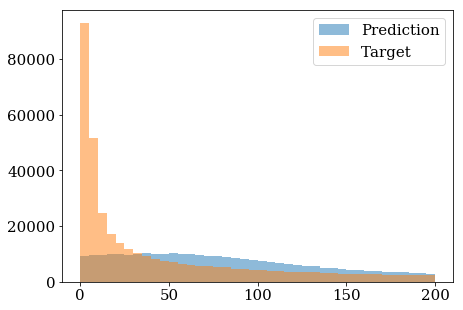

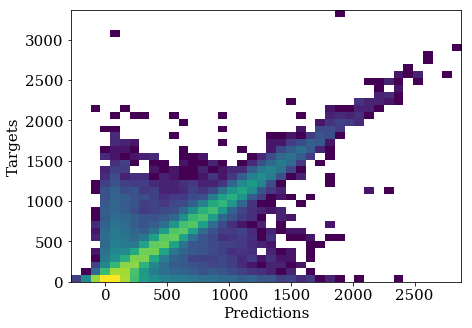

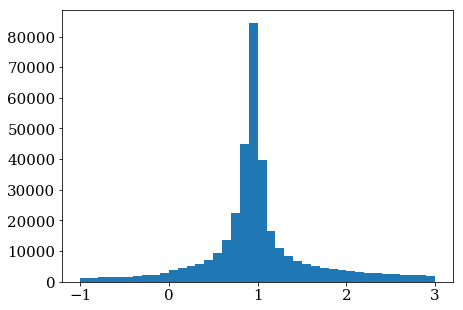

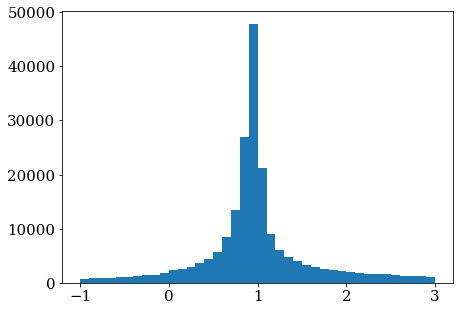

2.642781434545064


In [12]:
plt.figure()
plt.hist(all_preds.cpu().numpy(), bins=40, range=(0,200), alpha=0.5, label='Prediction')
plt.hist(all_targets.cpu().numpy(), bins=40, range = (0,200), alpha=0.5, label='Target')
plt.legend(loc='best')

print(all_preds.cpu().numpy().shape)
print(all_targets.cpu().numpy().shape)
plt.figure()
plt.hist2d(all_preds.cpu().numpy()[:,0], all_targets.cpu().numpy()[:,0], bins=40,norm=LogNorm())
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.show()

plt.figure()
ratio = all_preds.cpu().numpy()/(all_targets.cpu().numpy()+1e-7)
plt.hist(ratio, bins=40,range=(-1,3))


masked = all_weights.cpu().numpy()>0
plt.figure()
ratio = all_preds.cpu().numpy()[masked[:,0]]/(all_targets.cpu().numpy()[masked[:,0]]+1e-7)
plt.hist(ratio, bins=40, range=(-1,3))
plt.show()

def evaluate_loss(predictions, truth):  
     ratio = predictions/truth 
     a = np.nanpercentile(ratio, 84, interpolation='nearest')  
     b = np.nanpercentile(ratio, 16, interpolation='nearest')  
     c = np.nanpercentile(ratio, 50, interpolation='nearest')  
     loss = (a-b)/(2.*c)  
     return loss
print (evaluate_loss(all_preds.cpu().numpy()[masked[:,0]],all_targets.cpu().numpy()[masked[:,0]]))